# **Dataset used** : MNIST

# **Denoising** : Filter + Autoencoder

# **Comparison metrics** : Comparision of classification of Dataset with noise and after denoising along with PSNR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train images shape: {}".format(x_train.shape))
print("Test images shape: {}".format(x_test.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test labels shape: {}".format(y_test.shape))

11493376/11490434 [==============================] - 0s 0us/step
Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Train labels shape: (60000,)
Test labels shape: (10000,)


In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_expanded = np.expand_dims(x_train, axis=3)
x_test_expanded = np.expand_dims(x_test, axis=3)

print("Train images shape: {}".format(x_train_expanded.shape))
print("Test images shape: {}".format(x_test_expanded.shape))

Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


In [ ]:
noise_factor = 0.7
x_train_noisy = x_train_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_expanded.shape) 
x_test_noisy = x_test_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_expanded.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
def statistical_filter(img):
    filtered_images=[]
    for i in range(len(img)):
        my_img=img[i]
        X=cv2.GaussianBlur(my_img,(5,5),cv2.BORDER_DEFAULT)
        filtered_images.append(X)
    filtered_images = np.array(filtered_images)
    filtered_images = np.expand_dims(filtered_images, axis=3)
    return filtered_images

In [ ]:
x_train_filtered = statistical_filter(x_train_noisy)
x_test_filtered = statistical_filter(x_test_noisy)

In [ ]:
def encoder(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='encoder_conv1')(input_img)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='encoder_conv2')(x)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool2')(x)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv3')(x)
    return encoded


def decoder(encoded):
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv1')(encoded)
    x = UpSampling2D((2, 2), name='decoder_upsample1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='decoder_conv2')(x)
    x = UpSampling2D((2, 2), name='decoder_upsample2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='decoder_conv3')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_conv4')(x)
    return decoded

In [ ]:
input_img = Input(shape=(28, 28, 1))

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 14, 14, 16)        4624      
_________________________________________________________________
encoder_pool2 (MaxPooling2D) (None, 7, 7, 16)          0         
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 7, 7, 8)           1160      
_________________________________________________________________
decoder_conv1 (Conv2D)       (None, 7, 7, 8)           584   

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10)

modelChkpt = ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True) 

train_history = autoencoder.fit(x_train_filtered, x_train_expanded,
                epochs=47,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_filtered, x_test_expanded),
                callbacks=[modelChkpt, earlyStopping]
)

Epoch 1/47
469/469 [==============================] - 7s 16ms/step - loss: 0.2270 - val_loss: 0.1619
Epoch 2/47
469/469 [==============================] - 7s 14ms/step - loss: 0.1569 - val_loss: 0.1506
Epoch 3/47
469/469 [==============================] - 7s 14ms/step - loss: 0.1495 - val_loss: 0.1455
Epoch 4/47
469/469 [==============================] - 7s 14ms/step - loss: 0.1456 - val_loss: 0.1424
Epoch 5/47
469/469 [==============================] - 7s 14ms/step - loss: 0.1429 - val_loss: 0.1404
Epoch 6/47
469/469 [==============================] - 7s 14ms/step - loss: 0.1413 - val_loss: 0.1389
Epoch 7/47
469/469 [==============================] - 7s 14ms/step - loss: 0.1400 - val_loss: 0.1377
Epoch 8/47
469/469 [==============================] - 7s 14ms/step - loss: 0.1387 - val_loss: 0.1371
Epoch 9/47
469/469 [==============================] - 7s 15ms/step - loss: 0.1377 - val_loss: 0.1359
Epoch 10/47
469/469 [==============================] - 7s 15ms/step - loss: 0.1370 - val_lo

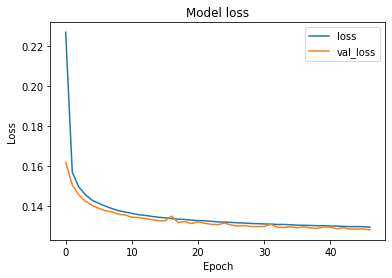

In [ ]:
plt.plot(train_history.history['loss'], label='loss')
plt.plot(train_history.history['val_loss'], label='val_loss')
plt.title("Model loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
x_test_denoised = autoencoder.predict(x_test_filtered)
x_train_denoised = autoencoder.predict(x_train_filtered)

In [ ]:
print(x_train_expanded.shape)
print(x_train_noisy.shape)
print(x_train_filtered.shape)
print(x_train_denoised.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
(60000, 28, 28, 1)
(60000, 28, 28, 1)


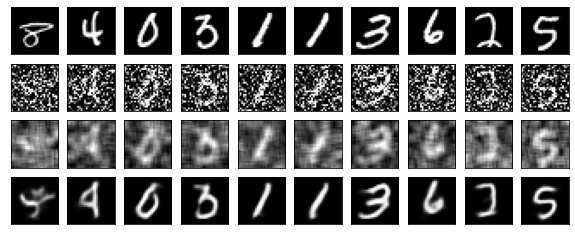

In [ ]:
n = 10
plt.figure(figsize=(10, 4))
for i in range(n):
    size = len(x_train)
    index = np.random.randint(0, size)
    plt.subplot(4, n, i+1)
    plt.imshow(x_train_expanded[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, n, n+i+1)
    plt.imshow(x_train_noisy[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, n, 2*n+i+1)
    plt.imshow(x_train_filtered[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, n, 3*n+i+1)
    plt.imshow(x_train_denoised[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
def cnn_classification(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print('Number of images in x_train', x_train.shape[0])
    print('Number of images in x_test', x_test.shape[0])
    classifier = keras.models.Sequential()
    classifier.add(keras.layers.Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
    classifier.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dense(128, activation=tf.nn.relu))
    classifier.add(keras.layers.Dropout(0.2))
    classifier.add(keras.layers.Dense(10,activation=tf.nn.softmax))
    classifier.summary()
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    classifier.fit(x=x_train,y=y_train, epochs=10)
    return classifier.evaluate(x_test, y_test)

In [ ]:
result1 = cnn_classification(x_train_noisy, y_train, x_test_noisy, y_test)

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               605824    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 607,3

In [ ]:
result2 = cnn_classification(x_train_denoised, y_train, x_test_denoised, y_test)

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               605824    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 607,3

In [ ]:
print("Accuracy with noise :",result1[1]*100)
print("Accuracy after denoising :",result2[1]*100)

Accuracy with noise : 89.44000005722046
Accuracy after denoising : 90.89999794960022


In [ ]:
im1 = tf.image.convert_image_dtype(x_train_noisy, tf.float32)
im2 = tf.image.convert_image_dtype(x_train_denoised, tf.float32)
psnr = tf.image.psnr(im1, im2, max_val=1.0)
psnr_train = np.mean(psnr)
print(psnr_train)

7.6947765
